# 基于天气数据集的XGBoost分类案例

In [29]:
from Boster import *
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 数据预处理

In [30]:
data = pd.read_csv('weather_cls.csv')
data = data.fillna(-1)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106644 entries, 0 to 106643
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           106644 non-null  object 
 1   Location       106644 non-null  object 
 2   MinTemp        106644 non-null  float64
 3   MaxTemp        106644 non-null  float64
 4   Rainfall       106644 non-null  float64
 5   Evaporation    106644 non-null  float64
 6   Sunshine       106644 non-null  float64
 7   WindGustDir    106644 non-null  object 
 8   WindGustSpeed  106644 non-null  float64
 9   WindDir9am     106644 non-null  object 
 10  WindDir3pm     106644 non-null  object 
 11  WindSpeed9am   106644 non-null  float64
 12  WindSpeed3pm   106644 non-null  float64
 13  Humidity9am    106644 non-null  float64
 14  Humidity3pm    106644 non-null  float64
 15  Pressure9am    106644 non-null  float64
 16  Pressure3pm    106644 non-null  float64
 17  Cloud9am       106644 non-nul

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2012/1/19,MountGinini,12.1,23.1,0.0,-1.0,-1.0,W,30.0,N,...,60.0,54.0,-1.0,-1.0,-1.0,-1.0,17.0,22.0,No,No
1,2015/4/13,Nhil,10.2,24.7,0.0,-1.0,-1.0,E,39.0,E,...,63.0,33.0,1021.9,1017.9,-1.0,-1.0,12.5,23.7,No,Yes
2,2010/8/5,Nuriootpa,-0.4,11.0,3.6,0.4,1.6,W,28.0,N,...,97.0,78.0,1025.9,1025.3,7.0,8.0,3.9,9.0,Yes,No
3,2013/3/18,Adelaide,13.2,22.6,0.0,15.4,11.0,SE,44.0,E,...,47.0,34.0,1025.0,1022.2,-1.0,-1.0,15.2,21.7,No,No
4,2011/2/16,Sale,14.1,28.6,0.0,6.6,6.7,E,28.0,NE,...,92.0,42.0,1018.0,1014.1,4.0,7.0,19.1,28.2,No,No


| 特征名称          | 意义      | 取值范围  |
|---------------|---------|-------|
| Date          | 日期      | 字符串   |
| Location      | 气象站的地址  | 字符串   |
| MinTemp       | 最低温度    | 实数    |
| MaxTemp       | 最高温度    | 实数    |
| Rainfall      | 降雨量     | 实数    |
| Evaporation   | 蒸发量     | 实数    |
| Sunshine      | 光照时间    | 实数    |
| WindGustDir   | 最强的风的方向 | 字符串   |
| WindGustSpeed | 最强的风的速度 | 实数    |


## 可视化描述

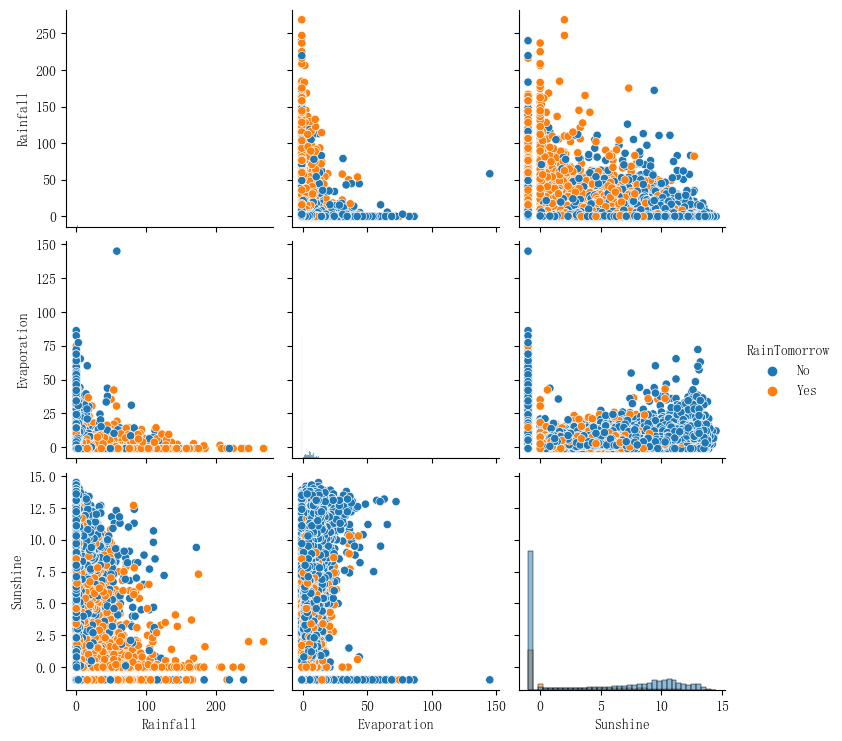

In [31]:
numerical_features = [x for x in data.columns if data[x].dtype == float]
category_features = [x for x in data.columns if data[x].dtype != float and x != 'RainTomorrow']
# 选取三个特征与标签组合的散点可视化
sns.pairplot(data=data[['Rainfall', 'Evaporation', 'Sunshine'] + ['RainTomorrow']], 
             diag_kind='hist', hue= 'RainTomorrow')
plt.show()

## 分类预测

In [32]:
# 把所有的相同类别的特征编码为同一个值
def get_mapfunction(x):
    mapp = dict(zip(x.unique().tolist(),
         range(len(x.unique().tolist()))))
    def mapfunction(y):
        if y in mapp:
            return mapp[y]
        else:
            return -1
    return mapfunction
for i in category_features:
    data[i] = data[i].apply(get_mapfunction(data[i]))
data['Location'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=int64)

In [33]:
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier

# 选择其类别为0和1的样本 （不包括类别为2的样本）
data_target_part = data['RainTomorrow']
data_features_part = data[[x for x in data.columns if x != 'RainTomorrow']]
# 测试集大小为20%
x_train, x_test, y_train, y_test = train_test_split(data_features_part, data_target_part, 
                                                    test_size=0.2, random_state=2020)

y_train = y_train.replace({'Yes': 1, 'No': 0})
y_test  = y_test.replace({'Yes': 1, 'No': 0})

print(y_train[0:2],y_test[0:2])

98173    0
33154    0
Name: RainTomorrow, dtype: int64 10273    1
90769    0
Name: RainTomorrow, dtype: int64


In [34]:
clf = XGBClassifier(use_label_encoder=False)
clf.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The accuracy of the XGBoost is: 0.9002637285354276
The accuracy of the XGBoost is: 0.8578930095175582
The confusion matrix result:
 [[15633  2111]
 [  920  2665]]


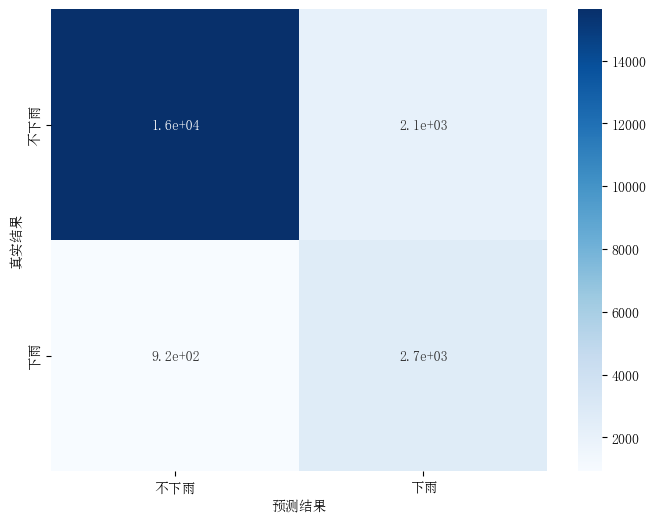

In [35]:
# 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)
from sklearn import metrics
print('The accuracy of the XGBoost is:',metrics.accuracy_score(y_train,train_predict))
print('The accuracy of the XGBoost is:',metrics.accuracy_score(y_test,test_predict))

# 查看混淆矩阵
confusion_matrix_result = metrics.confusion_matrix(test_predict, y_test)
print('The confusion matrix result:\n', confusion_matrix_result)
labels = ['不下雨', '下雨']

# 利用热力图对于结果进行可视化
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.rcParams['font.sans-serif'] = 'SimSun'  # 指定宋体绘制
plt.xlabel('预测结果')
plt.ylabel('真实结果')
# plt.title()
plt.savefig('src/heatsmap.png')
plt.show()

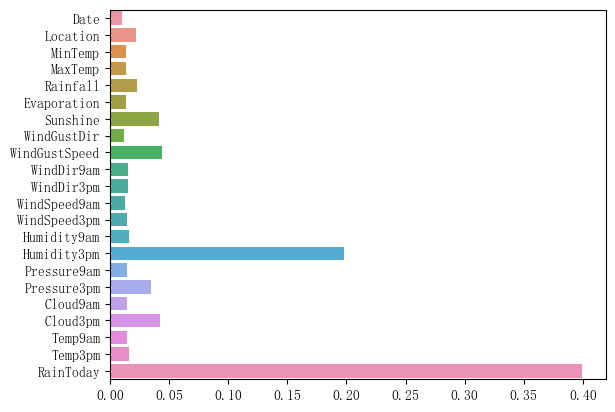

In [36]:
sns.barplot(y=data_features_part.columns, x=clf.feature_importances_)
plt.savefig('src/importance.png')

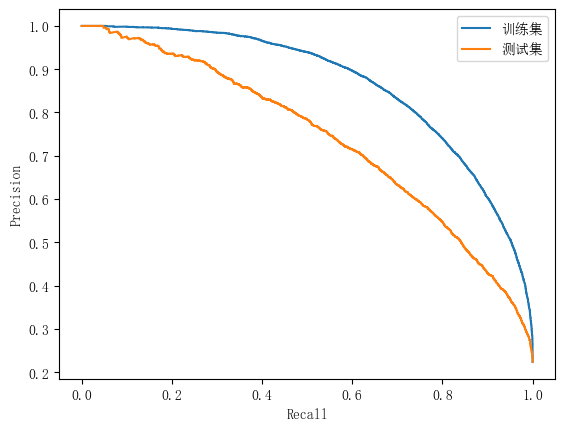

In [37]:
from sklearn.metrics import precision_recall_curve

# 计算训练集和测试集上的预测概率
train_probs = clf.predict_proba(x_train)[:, 1]
test_probs = clf.predict_proba(x_test)[:, 1]

# 计算训练集和测试集上的精确率、召回率和阈值
train_precision, train_recall, train_thresholds = precision_recall_curve(y_train, train_probs)
test_precision, test_recall, test_thresholds = precision_recall_curve(y_test, test_probs)

# 绘制PR曲线
plt.plot(train_recall, train_precision, label='训练集')
plt.plot(test_recall, test_precision, label='测试集')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig('src/PR Curve.png')
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 计算训练集和测试集上的预测结果
train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)

# 计算准确度（accuracy）
train_accuracy = accuracy_score(y_train, train_predict)
test_accuracy = accuracy_score(y_test, test_predict)
# 计算精确率（precision）
train_precision = precision_score(y_train, train_predict)
test_precision = precision_score(y_test, test_predict)
# 计算召回率（recall）
train_recall = recall_score(y_train, train_predict)
test_recall = recall_score(y_test, test_predict)
# 计算F1得分
train_f1_score = f1_score(y_train, train_predict)
test_f1_score = f1_score(y_test, test_predict)
print('Train Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)
print('Train Precision:', train_precision)
print('Test Precision:', test_precision)
print('Train Recall:', train_recall)
print('Test Recall:', test_recall)
print('Train F1 Score:', train_f1_score)
print('Test F1 Score:', test_f1_score)

Train Accuracy: 0.9002637285354276
Test Accuracy: 0.8578930095175582
Train Precision: 0.8569306596448586
Test Precision: 0.7433751743375174
Train Recall: 0.6651294413583482
Test Recall: 0.557998324958124
Train F1 Score: 0.7489452099253533
Test F1 Score: 0.6374835545987322
